# Compare Natural Cause Deaths in the US from 2019 to 2020

In [1]:
import os
import io
import re
import urllib

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_dba_url = "https://data.cdc.gov/api/views/vsak-wrfu/rows.csv?accessType=DOWNLOAD"
with urllib.request.urlopen(data_dba_url) as fh:
    deaths_by_age = pd.read_csv(fh)

In [13]:
deaths_by_age['End Week'] = pd.to_datetime(deaths_by_age['End Week'])

In [15]:
deaths_by_age = deaths_by_age.sort_values(by='End Week')

In [24]:
deaths_by_age_all = deaths_by_age[(deaths_by_age.Sex == 'All Sex') & (deaths_by_age['Age Group'] != 'All Ages')]

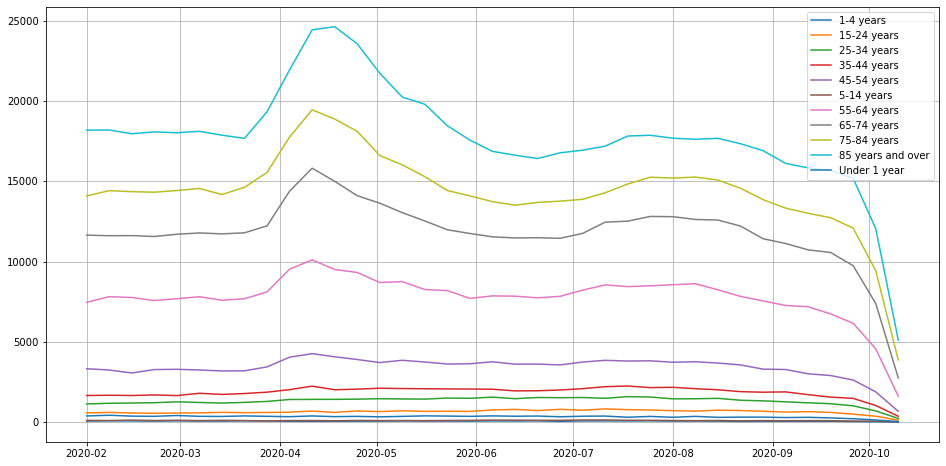

In [29]:
plt.figure(figsize=(16, 8))
for ag, ag_df in deaths_by_age_all.groupby('Age Group'):
    plt.plot(ag_df['End Week'], ag_df['Total Deaths'], label=ag)
    
plt.grid()
plt.legend()

## Load Weekly 2019/2020 Data

Data pulled from:

https://data.cdc.gov/NCHS/Weekly-Counts-of-Deaths-by-State-and-Select-Causes/muzy-jte6

In [2]:
data_url = "https://data.cdc.gov/api/views/muzy-jte6/rows.csv?accessType=DOWNLOAD"
with urllib.request.urlopen(data_url) as fh:
    weekly_deaths_by_state = pd.read_csv(fh)

In [3]:
weekly_deaths_by_state["Week Ending Date"] = pd.to_datetime(weekly_deaths_by_state["Week Ending Date"])
weekly_deaths_by_state["Month"] = weekly_deaths_by_state["Week Ending Date"].dt.month
weekly_deaths_by_state["Year"] = weekly_deaths_by_state["Week Ending Date"].dt.year

In [15]:
weekly_deaths_by_state['Non-Natural Cause'] = weekly_deaths_by_state['All Cause'] - weekly_deaths_by_state['Natural Cause']

In [16]:
# Filter to United States
# States are listed as well, but US has the sums
mortality_counts_recent = weekly_deaths_by_state\
    [weekly_deaths_by_state['Jurisdiction of Occurrence'] == 'United States']\
    .groupby(['Year', 'Month'])\
    .agg({'Natural Cause': 'sum', 'All Cause': 'sum', 'Non-Natural Cause': 'sum'})\
    .reset_index()

mortality_counts_recent.sample(3)

,Year,Month,Natural Cause,All Cause,Non-Natural Cause
2,2019,3,265197.0,288779.0,23582.0
6,2019,7,187708.0,208194.0,20486.0
8,2019,9,188692.0,208503.0,19811.0


In [17]:
year_comparison = pd.merge(
    mortality_counts_recent[mortality_counts_recent.Year == 2019],
    mortality_counts_recent[mortality_counts_recent.Year == 2020],
    on=['Month'],
    suffixes=('_2019', '_2020'))

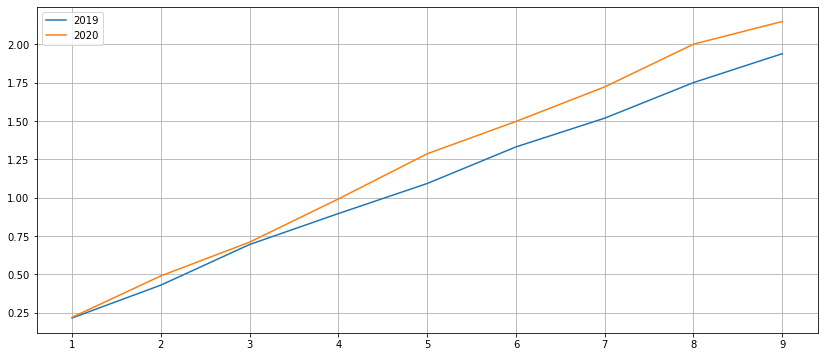

In [18]:
plt.figure(figsize=(14, 6))
for year in [2019, 2020]:
    plt.plot(year_comparison.Month, year_comparison[f"Natural Cause_{year}"].cumsum() / 1000000, label=year)
plt.legend()
plt.grid()
plt.show()

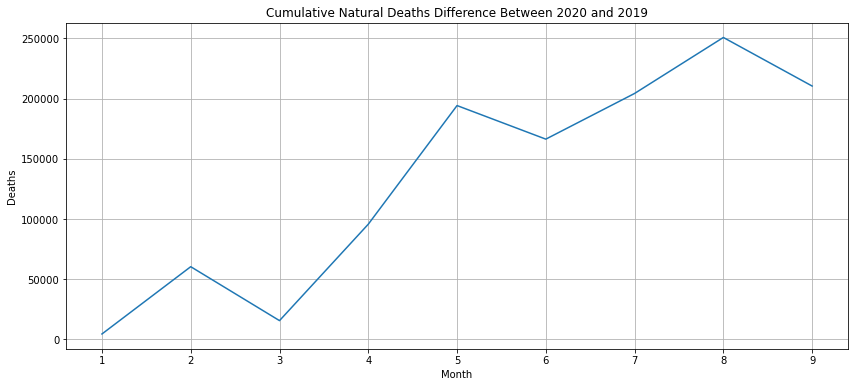

In [19]:
plt.figure(figsize=(14, 6))
plt.plot(
    year_comparison.Month,
    year_comparison["Natural Cause_2020"].cumsum() - year_comparison["Natural Cause_2019"].cumsum())
plt.title("Cumulative Natural Deaths Difference Between 2020 and 2019")
plt.grid()
plt.xlabel("Month")
plt.ylabel("Deaths")
plt.show()

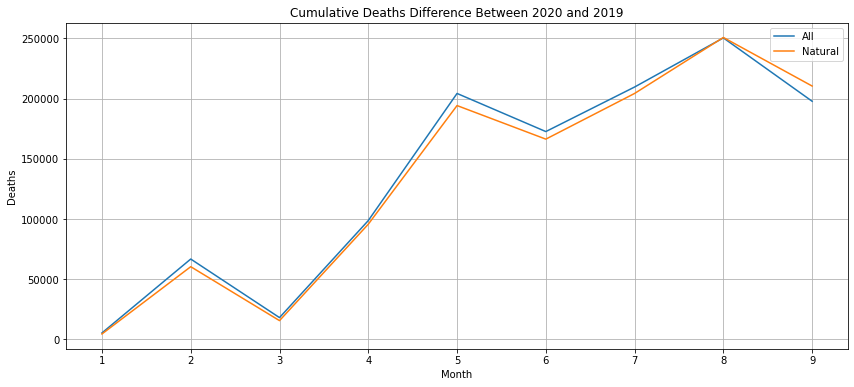

In [12]:
plt.figure(figsize=(14, 6))
plt.plot(
    year_comparison.Month,
    year_comparison["All Cause_2020"].cumsum() - year_comparison["All Cause_2019"].cumsum(), label="All")
plt.plot(
    year_comparison.Month,
    year_comparison["Natural Cause_2020"].cumsum() - year_comparison["Natural Cause_2019"].cumsum(), label="Natural")
plt.title("Cumulative Deaths Difference Between 2020 and 2019")
plt.grid()
plt.legend()
plt.xlabel("Month")
plt.ylabel("Deaths")
plt.show()

### Non-Natural Deaths

Non natural deaths have gone down.

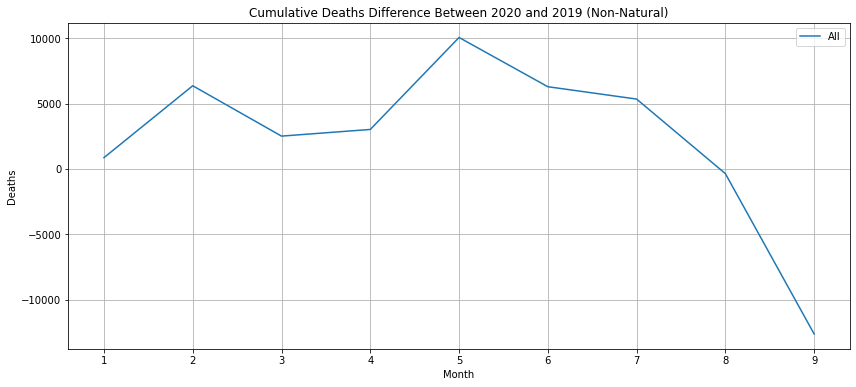

In [21]:
plt.figure(figsize=(14, 6))
plt.plot(
    year_comparison.Month,
    year_comparison["Non-Natural Cause_2020"].cumsum() - year_comparison["Non-Natural Cause_2019"].cumsum(), label="All")
plt.title("Cumulative Deaths Difference Between 2020 and 2019 (Non-Natural)")
plt.grid()
plt.legend()
plt.xlabel("Month")
plt.ylabel("Deaths")
plt.show()

## Examine Differences By State

In [78]:
state_deaths = weekly_deaths_by_state[weekly_deaths_by_state['Jurisdiction of Occurrence'] != 'United States']
state_deaths = state_deaths.rename(columns={'Jurisdiction of Occurrence': 'State'})
state_deaths = state_deaths.groupby(['State', 'Year', 'Month']).agg({'Natural Cause': 'sum'}).reset_index()

def add_cumsums(df):
    df = df.sort_values(by=['Year', 'Month'])
    df['Natural Cause Cummulative'] = df['Natural Cause'].cumsum()
    return df

state_deaths = state_deaths[['State', 'Year', 'Month', 'Natural Cause']].groupby(['State', 'Year']).apply(add_cumsums).reset_index(drop=True)

In [85]:
state_deaths_comp = pd.merge(
    state_deaths[state_deaths.Year == 2019],
    state_deaths[state_deaths.Year == 2020],
    on=['State', 'Month'],
    suffixes=("_2019", "_2020")
)    

state_deaths_comp['Natural Cause Percent Change'] = 100 * \
    (state_deaths_comp['Natural Cause Cummulative_2020'] - state_deaths_comp['Natural Cause Cummulative_2019']) \
    / state_deaths_comp['Natural Cause Cummulative_2019']

In [89]:
comp_month = state_deaths_comp.Month.max() - 1
state_deaths_prev_month = state_deaths_comp[state_deaths_comp.Month == comp_month].sort_values(by='Natural Cause Percent Change', ascending=False)

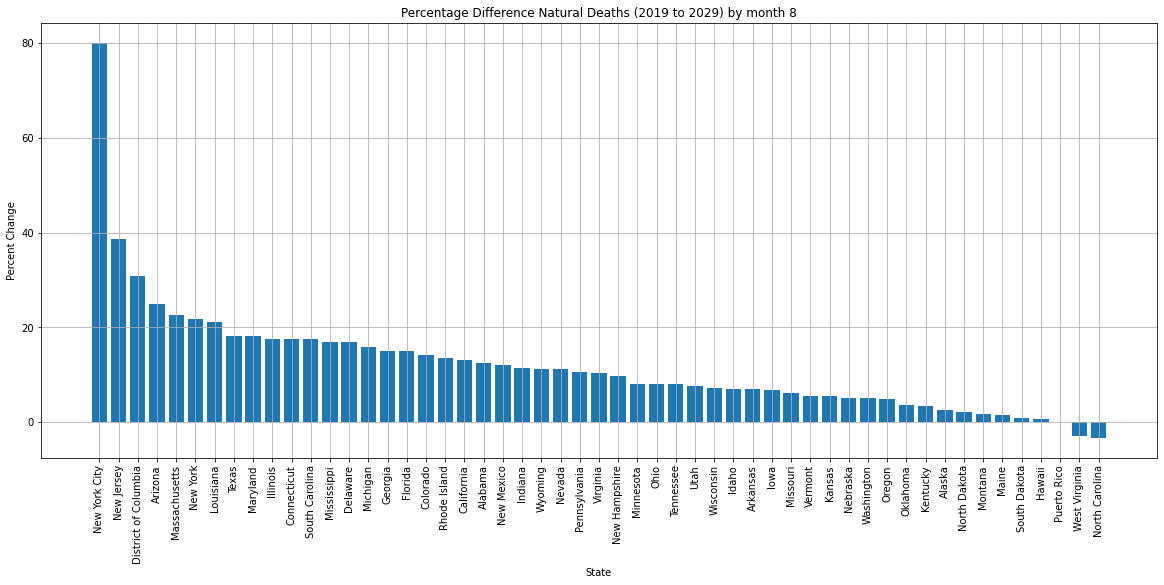

In [94]:
plt.figure(figsize=(20, 8))
plt.bar(state_deaths_prev_month.State, state_deaths_prev_month['Natural Cause Percent Change'])
plt.xticks(rotation=90)
plt.title(f"Percentage Difference Natural Deaths (2019 to 2029) by month {comp_month}")
plt.xlabel("State")
plt.ylabel("Percent Change")
plt.grid()
plt.show()